In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

base_dir = "/content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/"
print("Available folders:", os.listdir(base_dir))


Available folders: ['overview.csv', 'VX', 'WD', 'VY', 'DEM']


In [ ]:
import numpy as np

def run_ca_swegnn(
    Z,
    dx,
    t_end,
    inflow_mask,
    Q_in=50.0,
    n_manning=0.03,
    theta=0.7,
    CFL=1.0,
    dt_min=0.5,
    dt_max=15.0,
    depth_threshold=0.01,
):
    """
    Parameters
    ----------
    Z : (ny, nx) array
        Ground elevation.
    dx : float
        Grid resolution (m).
    t_end : float
        Final time (s).
    inflow_mask : boolean
        True where inflow occurs
    Q_in : float
        Constant inflow discharge [m³/s].
    n_manning : float
        Manning roughness coefficient.
    theta : float
        Relaxation parameter (0–1).
    CFL : float
        Courant number.
    dt_min, dt_max : float
        Min/max allowable time step.
    depth_threshold : float
        Wet-dry threshold.
    """

    # ---------------------------------------------
    # Initialization
    # ---------------------------------------------
    Z = np.asarray(Z, float)
    ny, nx = Z.shape
    A = dx * dx

    """
    Initially dry bed therefore water level is
    same as the elevation
    """

    d  = np.zeros_like(Z)       # depth
    WL = Z.copy()               # water level

    """
    Boolean which is true where the inflow happens and false where it does not
    """
    inflow_mask = inflow_mask.astype(bool)

    """
    During the simulation need to know:
    - The top cell above each cell
    - The bottom cell below each cell
    - The left cell
    - The right cell
    Computing these neighbor grids once
    - For top row, we copy it and duplicate it and stack all the rows except the last row
    - For bottom row, duplicate last row
    - Left edge repeats itself
    - Right edge repeats itself
    """

    # Precompute neighbor topography
    Z_up = np.vstack([Z[0:1, :], Z[:-1, :]]) #Duplicate the first row, all rows except last row
    Z_dn = np.vstack([Z[1:, :], Z[-1:, :]])  #Row 1 till end and copy last row
    Z_lt = np.hstack([Z[:, 0:1], Z[:, :-1]]) #Leftmost column copied, all columns except last
    Z_rt = np.hstack([Z[:, 1:], Z[:, -1:]])  #columns 1 till end, copy last column

    """
    Want to store the depths every 30 minutes so that can compare it with the
    SWE-GNN dataset

    """
    t = 0.0
    step = 0

    # ---------------------------------------------
    # For storing depth snapshots
    # ---------------------------------------------
    dt_output = 1800 #save depth every 30 mins (in seconds)
    sample_times = []
    depth_samples = []
    next_sample_time = 0

    # ---------------------------------------------
    # Manning + Critical Velocity Cap
    # ---------------------------------------------
    def vcap(d_if, slope):
        # Eq. 6 from Ghimire et al. (2013)
        slope = np.maximum(slope, 1e-4)
        d_if = np.maximum(d_if, 1e-4)

        v_m = (1.0 / n_manning) * (d_if ** (2/3)) * np.sqrt(slope)
        v_c = np.sqrt(9.81 * d_if)

        return np.minimum(v_m, v_c)

    # ---------------------------------------------
    # Compute time step – CFL based
    # ---------------------------------------------
    def compute_dt(WL):
        WL_up = np.vstack([WL[0:1, :], WL[:-1, :]])
        WL_dn = np.vstack([WL[1:, :], WL[-1:, :]])
        WL_lt = np.hstack([WL[:, 0:1], WL[:, :-1]])
        WL_rt = np.hstack([WL[:, 1:], WL[:, -1:]])

        d_if_up = np.maximum(np.maximum(WL, WL_up) - np.maximum(Z, Z_up), 0.0)
        d_if_dn = np.maximum(np.maximum(WL, WL_dn) - np.maximum(Z, Z_dn), 0.0)
        d_if_lt = np.maximum(np.maximum(WL, WL_lt) - np.maximum(Z, Z_lt), 0.0)
        d_if_rt = np.maximum(np.maximum(WL, WL_rt) - np.maximum(Z, Z_rt), 0.0)

        dWL_up = np.maximum(WL - WL_up, 0.0) / dx
        dWL_dn = np.maximum(WL - WL_dn, 0.0) / dx
        dWL_lt = np.maximum(WL - WL_lt, 0.0) / dx
        dWL_rt = np.maximum(WL - WL_rt, 0.0) / dx

        v_up = vcap(d_if_up, dWL_up)
        v_dn = vcap(d_if_dn, dWL_dn)
        v_lt = vcap(d_if_lt, dWL_lt)
        v_rt = vcap(d_if_rt, dWL_rt)

        vmax = float(max(v_up.max(), v_dn.max(), v_lt.max(), v_rt.max(), 1e-10))
        dt = CFL * dx / vmax

        """
        np.clip(x, a, b)
        - if x < a -> a
        - if x > b -> b
        dt<dt_min -> dt = dt_min
        dt>dt_max -> dt = dt_max
        """
        #return float(np.clip(dt, dt_min, dt_max))
        return dt #Trying without the clip

    # =========================================================================
    # MAIN LOOP
    # =========================================================================
    while t < t_end:

        # Compute dt based on wet fraction
        wet_fraction = np.count_nonzero(d > depth_threshold) / d.size
        dt = dt_max if wet_fraction < 0.002 else compute_dt(WL)
        """
        - This is to prevent overshoot the final time
        - This will make sure that dt stops exactly at t_end
          and does not go beyond it
        """
        if t + dt > t_end:
            dt = t_end - t

        # ---------------------------------------------------------------------
        # CONSTANT INFLOW
        # ---------------------------------------------------------------------
        # Add pure mass as volume = Q_in * dt
        if Q_in > 0:
            vol_in = Q_in * dt
            dh_in  = vol_in / A
            d[inflow_mask] += dh_in
            WL[inflow_mask] = Z[inflow_mask] + d[inflow_mask]

        # ---------------------------------------------------------------------
        # NEIGHBOUR WATER LEVELS
        # ---------------------------------------------------------------------
        WL_up = np.vstack([WL[0:1, :], WL[:-1, :]])
        WL_dn = np.vstack([WL[1:, :], WL[-1:, :]])
        WL_lt = np.hstack([WL[:, 0:1], WL[:, :-1]])
        WL_rt = np.hstack([WL[:, 1:], WL[:, -1:]])

        # Interfacial water depths
        d_if_up = np.maximum(np.maximum(WL, WL_up) - np.maximum(Z, Z_up), 0.0)
        d_if_dn = np.maximum(np.maximum(WL, WL_dn) - np.maximum(Z, Z_dn), 0.0)
        d_if_lt = np.maximum(np.maximum(WL, WL_lt) - np.maximum(Z, Z_lt), 0.0)
        d_if_rt = np.maximum(np.maximum(WL, WL_rt) - np.maximum(Z, Z_rt), 0.0)

        # Water surface slopes
        dWL_up = np.maximum(WL - WL_up, 0.0) / dx
        dWL_dn = np.maximum(WL - WL_dn, 0.0) / dx
        dWL_lt = np.maximum(WL - WL_lt, 0.0) / dx
        dWL_rt = np.maximum(WL - WL_rt, 0.0) / dx

        # Velocity caps
        v_up = vcap(d_if_up, dWL_up)
        v_dn = vcap(d_if_dn, dWL_dn)
        v_lt = vcap(d_if_lt, dWL_lt)
        v_rt = vcap(d_if_rt, dWL_rt)

        # Fluxes: F = v * depth * dx * dt
        F_up = v_up * d_if_up * dx * dt
        F_dn = v_dn * d_if_dn * dx * dt
        F_lt = v_lt * d_if_lt * dx * dt
        F_rt = v_rt * d_if_rt * dx * dt

        # Volume check
        V = d * A   #Checks volume in every grid cell
        total_out = F_up + F_dn + F_lt + F_rt
        mask = total_out > V
        if mask.any():
            scale = V / np.maximum(total_out, 1e-12)
            F_up *= scale
            F_dn *= scale
            F_lt *= scale
            F_rt *= scale

        # Net volume change from neighbours (Eq. 3 concept)
        dV = np.zeros_like(V)

        # Up-down fluxes
        dV -= F_up
        dV[1:, :] += F_dn[:-1, :]
        dV -= F_dn
        dV[:-1, :] += F_up[1:, :]

        # Left-right fluxes
        dV -= F_lt
        dV[:, 1:] += F_rt[:, :-1]
        dV -= F_rt
        dV[:, :-1] += F_lt[:, 1:]

        # Update depths with relaxation (Eq. 3)
        d = np.maximum(d + theta * (dV / A), 0.0)
        WL = Z + d

        # ---------------------------------------------------------------------
        # Store snapshots
        # ---------------------------------------------------------------------
        t += dt
        step += 1

        #Save depth if we have crossed output time
        if t >= next_sample_time:
          sample_times.append(t)
          depth_samples.append(d.copy())
          next_sample_time += dt_output

    sample_times_out = np.array(sample_times)
    depth_samples = np.stack(depth_samples, axis = 0)

    return sample_times_out, depth_samples


In [ ]:
# ============================================================================
# FUNCTION 2: Load and Plot WD (Final Time Step Only)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np


def load_and_plot_final_wd(base_path, sim_id):
    """
    Load the WD file and plot ONLY the final water depth map.
    Assumes WD_simID.txt contains: time-steps × number-of-cells.
    """

    wd_file = os.path.join(base_path, "WD", f"WD_{sim_id}.txt")
    print(f"\nLoading WD file: {wd_file}")

    # Load the full WD matrix
    WD_raw = np.loadtxt(wd_file)
    n_times, n_cells = WD_raw.shape

    print(f"WD matrix shape: {n_times} time steps × {n_cells} cells")

    # Create a synthetic time vector (if no time column is present)
    times = np.arange(n_times)

    # Try to infer grid shape (assume square-like)
    sqrt_n = int(np.sqrt(n_cells))
    ny_wd, nx_wd = None, None

    for n in range(sqrt_n, sqrt_n + 10):
        if n_cells % n == 0:
            nx_wd = n
            ny_wd = n_cells // n
            break

    # If no perfect factorization found, fallback to padded square
    if ny_wd is None:
        print("Grid is not factorizable. Using square grid with padding.")
        nx_wd = ny_wd = sqrt_n
        padded = np.zeros((n_times, nx_wd * ny_wd))
        padded[:, :n_cells] = WD_raw
        WD_raw = padded

    print(f"WD grid: {ny_wd} rows × {nx_wd} columns")

    # Reshape into (time, y, x)
    WD = WD_raw.reshape(n_times, ny_wd, nx_wd)

    # Extract final depth field
    final_depth = WD[-1]

    # Plot final WD map
    plt.figure(figsize=(8, 6))
    plt.imshow(final_depth, cmap="Blues", origin="lower")
    plt.colorbar(label="Water depth (m)")
    plt.title(f"Final water depth (simulation {sim_id})")
    plt.xlabel("X index")
    plt.ylabel("Y index")
    plt.tight_layout()
    plt.show()

    return WD, times

In [ ]:
def load_dem_from_swegnn(base_path, sim_id):
    """
    Load DEM from SWE-GNN dataset format.
    Plots the elevation map.

    Parameters
    ----------
    base_path : str
        Path to the dataset directory
    sim_id : int
        Simulation ID number

    Returns
    -------
    X, Y, Z : arrays
        Grid coordinates and elevation
    """
    dem_file = os.path.join(base_path, "DEM", f"DEM_{sim_id}.txt")
    print(f"Loading DEM_{sim_id}.txt...")

    # Load data
    data = np.loadtxt(dem_file)
    x_raw = data[:, 0]
    y_raw = data[:, 1]
    z_raw = data[:, 2]

    # Get unique values to find grid size
    xs = np.unique(x_raw)
    ys = np.unique(y_raw)

    ny = len(ys)
    nx = len(xs)

    print(f"DEM grid: {ny} x {nx} = {ny * nx} cells")

    # Reshape to 2D grids
    X = x_raw.reshape(ny, nx)
    Y = y_raw.reshape(ny, nx)
    Z = z_raw.reshape(ny, nx)

    print(f"Elevation range: {Z.min():.2f} to {Z.max():.2f} m")

    # ----------------------------------------------------
    # PLOT DEM
    # ----------------------------------------------------
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(X, Y, Z, cmap="terrain", shading="auto")
    plt.colorbar(label="Elevation (m)")
    plt.title(f"DEM {sim_id}: Elevation Map", fontsize=14)
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.tight_layout()
    plt.show()

    return X, Y, Z


def plot_flood_depth(water_depth, sim_id):
    """
    Plot water depth map.

    Parameters
    ----------
    water_depth : array (ny, nx)
        Water depth in meters
    title : str
        Plot title
    save_path : str or None
        If provided, save figure to this path
    """
    plt.figure(figsize=(10, 8))

    #Final flood depth
    final_depth = water_depth[-1]

    # Create plot
    im = plt.imshow(final_depth, cmap="Blues", origin="lower", vmin=0)
    plt.colorbar(im, label="Water Depth (m)")

    # Add statistics
    wet_cells = np.sum(water_depth > 0.01)
    total_cells = water_depth.size
    max_depth = water_depth.max()

    plt.title(f"Final Flood Depth Map for {sim_id}")
    plt.xlabel("X index")
    plt.ylabel("Y index")

    plt.tight_layout()
    plt.show()


def create_breach_mask(grid_shape, row_start, row_end, col_start, col_end):
    """
    Create a manual breach/inflow mask using simple start/end indices.

    Parameters
    ----------
    grid_shape : (ny, nx)
        Shape of the domain
    row_start : int
        Starting row index
    row_end : int
        Ending row index (inclusive)
    col_start : int
        Starting column index
    col_end : int
        Ending column index (inclusive)

    Returns
    -------
    mask : boolean array (ny, nx)
        True where inflow should enter
    """

    ny, nx = grid_shape
    mask = np.zeros((ny, nx), dtype=bool)

    # Apply True over rectangle
    mask[row_start:row_end+1, col_start:col_end+1] = True

    return mask

def plot_breach_on_dem(Z, mask, title="Breach Location on DEM"):
    """
    Plot the DEM and overlay the breach/inflow mask.

    Parameters
    ----------
    Z : 2D array
        DEM elevation grid.
    mask : 2D bool array
        Inflow mask where True indicates breach cells.
    title : str
        Plot title.
    """

    plt.figure(figsize=(10, 8))

    # Plot DEM
    plt.imshow(Z, cmap="terrain", origin="lower")
    plt.colorbar(label="Elevation (m)")

    # Overlay mask in red
    breach_y, breach_x = np.where(mask)
    plt.scatter(breach_x, breach_y, color="red", s=20, label="Breach Cells")

    plt.title(title, fontsize=14)
    plt.xlabel("X index")
    plt.ylabel("Y index")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_CA_vs_WD(final_CA_depth, final_WD_depth, title="CA vs Delft-3D"):
    """
    Plot side-by-side comparison of final CA flood depth and Delft-3D (ground truth).
    """

    plt.figure(figsize=(14, 6))

    # --- CA Flood Depth ---
    plt.subplot(1, 2, 1)
    plt.imshow(final_CA_depth, origin="lower", cmap="Blues")
    plt.colorbar(label="Depth (m)")
    plt.title("Final CA Flood Depth")
    plt.xlabel("X index")
    plt.ylabel("Y index")

    # --- SWE-GNN WD Flood Depth ---
    plt.subplot(1, 2, 2)
    plt.imshow(final_WD_depth, origin="lower", cmap="Blues")
    plt.colorbar(label="Depth (m)")
    plt.title("Delft-3D Depth")
    plt.xlabel("X index")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


Loading DEM_2.txt...
DEM grid: 64 x 64 = 4096 cells
Elevation range: -3.49 to 4.46 m


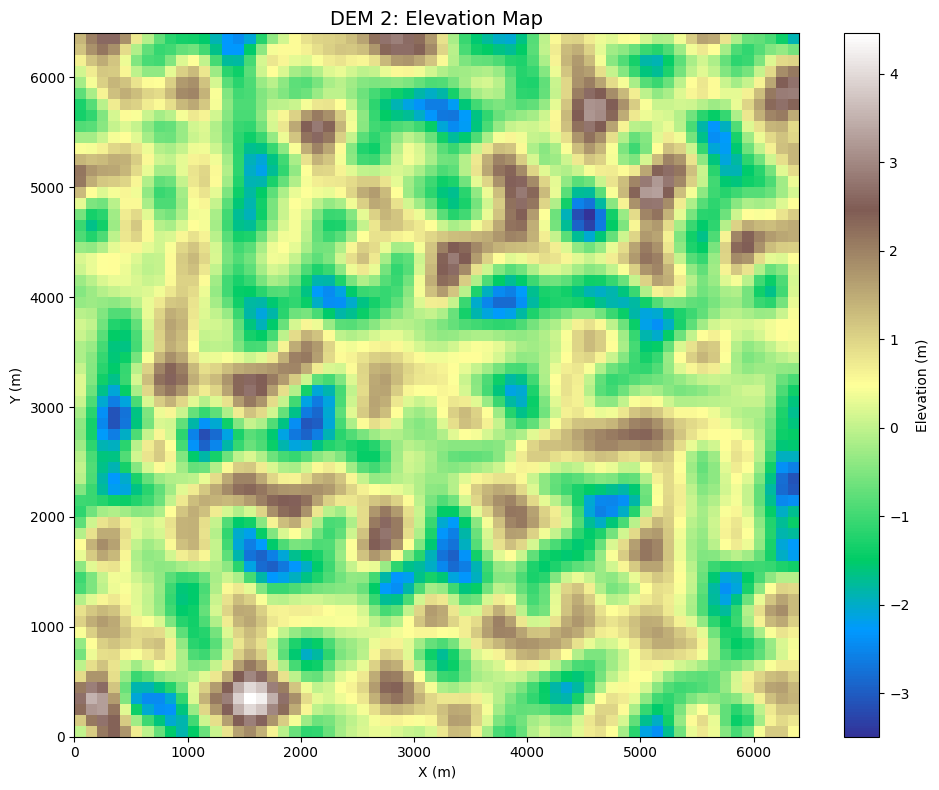

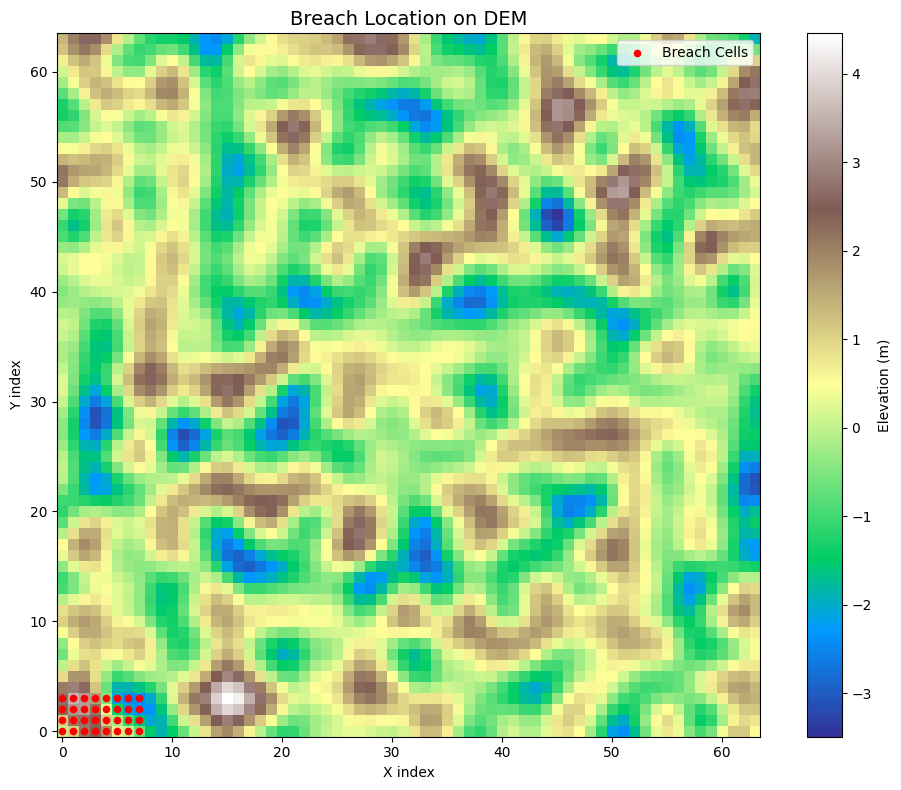

In [ ]:
X2, Y2, Z2 = load_dem_from_swegnn(base_dir, 2)
mask_2 = create_breach_mask(Z2.shape, 0, 3, 0, 7)
plot_breach_on_dem(Z2, mask_2)
sample_time_2, depth_samples_2 = run_ca_swegnn(Z2, 100, 48*3600, mask_2)


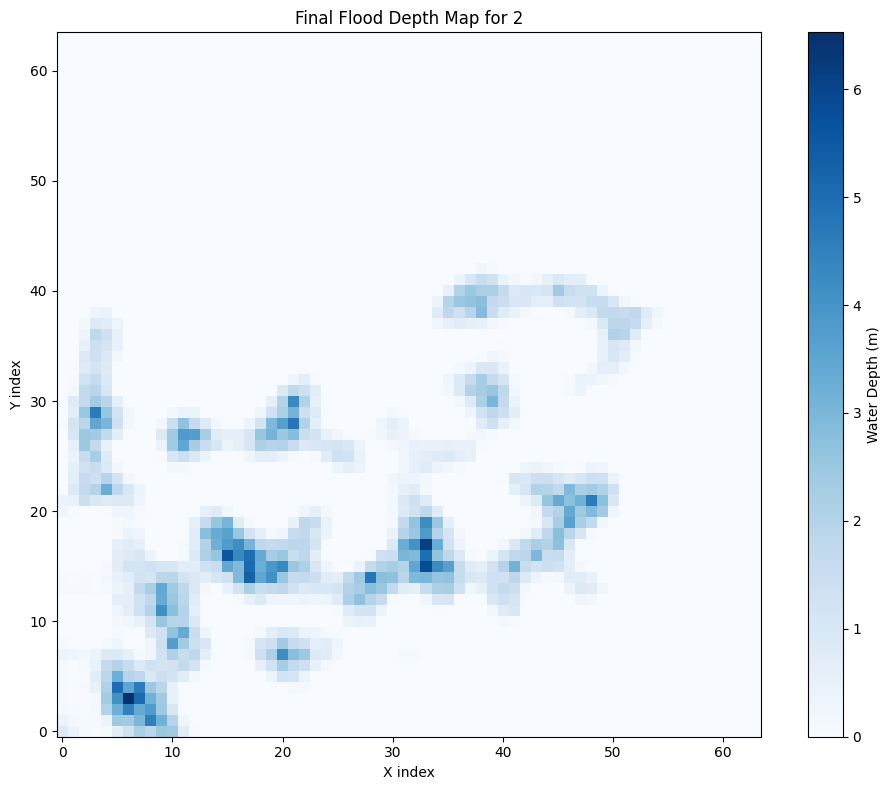

In [ ]:
plot_flood_depth(depth_samples_2, 2)


Loading WD file: /content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/WD/WD_2.txt
WD matrix shape: 97 time steps × 4096 cells
WD grid: 64 rows × 64 columns


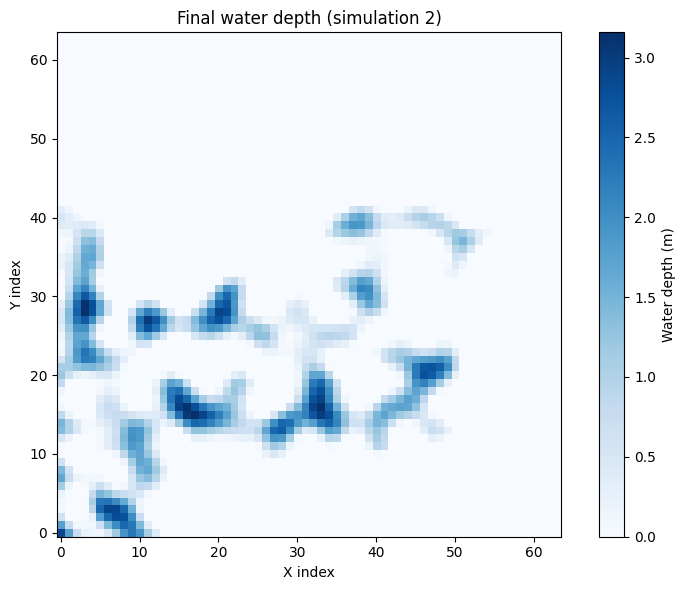

In [ ]:
#Comparing the CA flood with the Delft-3D ground truth
WD_2, times_2 = load_and_plot_final_wd(base_dir, 2)

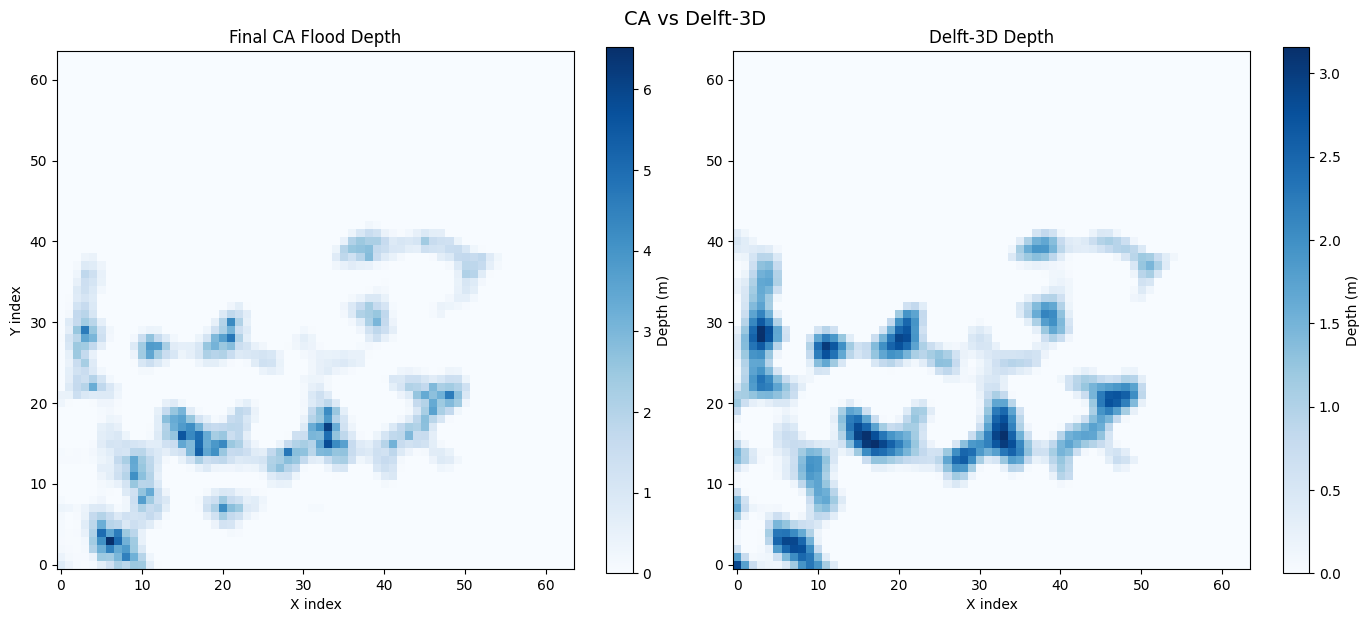

In [ ]:
final_CA = depth_samples_2[-1]
final_WD = WD_2[-1]

plot_CA_vs_WD(final_CA, final_WD)